In [2]:
%run convention.ipynb

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<p class = 'highlight'>Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.
</p>

# Voting classifiers

## Hard Voting

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier is called a <b>hard voting</b> classifier
<img src = 'hardvoting.png'>

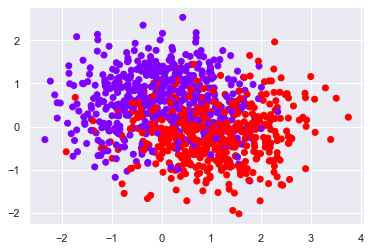

In [12]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples = 1000, noise = .6, random_state = 42)
plt.scatter(X[:,0], X[:,1], c = y, cmap = 'rainbow')



In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,  y_test = train_test_split(X, y, random_state = 6)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log = LogisticRegression()
ran = RandomForestClassifier()
svm = SVC()
vote = VotingClassifier([
    ('log', log),
    ('ran', ran),
    ('svm', svm)
], voting = 'hard')

for clf in (log, ran, svm, vote):
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print('%s: %.3f' % (clf.__class__.__name__, test_score))

LogisticRegression: 0.796
RandomForestClassifier: 0.720
SVC: 0.788
VotingClassifier: 0.792


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Soft Voting

If all classifiers are able to estimate class probabilities (i.e., they have a <code>predict_proba()</code> method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called <code>soft voting</code>. It often achieves higher performance than <code>hard voting</code> because it gives more
weight to highly confident votes. All you need to do is replace <code>voting="hard"</code> with
<code>voting="soft"</code> and ensure that all classifiers can estimate class probabilities. This is
not the case of the <code>SVC</code> class by default, so you need to set <code>probability  = True</code> (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a <code>predict_proba()</code> method). 

In [19]:
log = LogisticRegression()
ran = RandomForestClassifier(max_depth = 3)
svm = SVC(probability=True)
vote = VotingClassifier([
    ('log', log),
    ('ran', ran),
    ('svm', svm)
], voting = 'soft')

for clf in (log, ran, svm, vote):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('%s %.2f' % (clf.__class__.__name__, score))

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.80
RandomForestClassifier 0.77
SVC 0.79
VotingClassifier 0.78


# Bagging and Pasting

One way to get a diverse set of classifiers is to use very <u>different training algorithms</u>,
as just discussed. Another approach is to use the same training algorithm for every
predictor, but to train them on different random subsets of the training set. When
<b>sampling is performed <u>with replacement</u></b>, this method is called <span class = 'note'>bagging1</span>
(short for <span class = 'note'>bootstrap aggregating</span>). When <b>sampling is performed <u>without replacement</u></b>(disjoint subsets), it is called
<span class = 'note'>pasting</span>.


<img src = 'bagging.png'>

<p class = 'highlight'>
Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set.
</p>

predictors can all be trained in <u>parallel</u>, via <b>different
CPU cores or even different servers</b>. Similarly, predictions can be made in parallel.
This is one of the reasons why bagging and pasting are such popular methods: they
scale very well.


## Scikit learn: <code>BaggingClassifier</code> and <code>BaggingRegressor</code>

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X, y = make_moons(n_samples = 1000, noise = .2, random_state = 33)
dt = DecisionTreeClassifier()
rf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, n_jobs=-1, random_state = 42)
dt.fit(X, y)
rf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [24]:
def plot_decision_boundary(model, X, y, ax):
    mglearn.discrete_scatter(X[:,0], X[:,1], y, ax = ax)
    mglearn.plots.plot_2d_classification(model, X, alpha = .3, ax = ax)
    mglearn.plots.plot_2d_separator(model, X, ax = ax)

Text(0.5, 1.0, 'Decision Tree with Bagging')

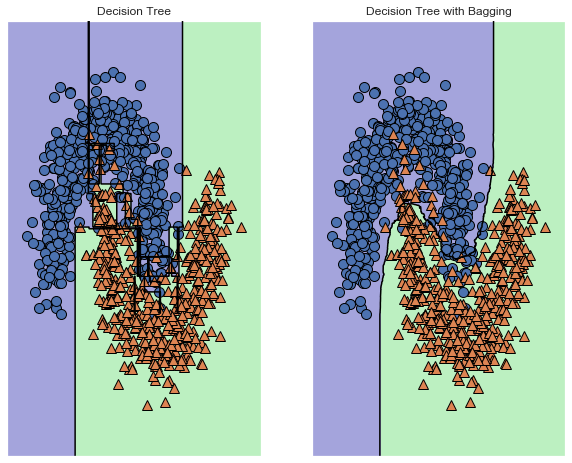

In [29]:
fig, axes = plt.subplots(1,2,subplot_kw = {'xticks':[], 'yticks':[]}, figsize = (10, 8))
plot_decision_boundary(dt, X, y, ax = axes[0])
plot_decision_boundary(rf, X, y, ax = axes[1])
axes[0].set_title('Decision Tree')
axes[1].set_title('Decision Tree with Bagging')

As you can see, the ensemble's predictions will likely generalize much better than the single Decision Tree's prediction. It makes roughly the same amount of bias, but smaller variance (the decision boundary is less irregular)

<p class = 'note'>In bagging, in models are uncorrelated (they make different mistakes), then the variance will be reduced greatly.


Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is gen‐
erally preferred. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

# Out-of-bag evaluation

<img src = 'oob.png'>

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(300, noise = .4, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100,oob_score=True)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [9]:
'Out-of-bag score: {}'.format(bag.oob_score_)

'Out-of-bag score: 0.84'

In [10]:
'Test score: {}'.format(bag.score(X_test, y_test))

'Test score: 0.8266666666666667'

## Random Patches and Random Subspaces

<img src = 'random.png'>

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.84

## Extra Tree

<img src = 'extratree.png'>

## Feature Importance

<code>RandomForestClassifier.feature_importance_</code>

# Boosting

## Ada Boost

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
params = {'learning_rate' : [0.001, 0.01, .1, 1, 10, 100]}
clf = AdaBoostClassifier(RandomForestClassifier(max_depth = 1))

clf.fit(X_train, y_train)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: Future

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators='warn',
                        

In [21]:
clf.score(X_test, y_test)

0.7866666666666666

<p class = 'highlight box'>If your AdaBoost ensemble is overfitting the training set, you can
try reducing the number of estimators or more strongly regularizing the base estimator</p>

## Gradient Boosting


The <code>GradientBoostingRegressor</code> class also supports a <code>subsample</code> hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if <b>subsample=0.25</b>, then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this trades a higher bias
for a lower variance. It also speeds up training considerably. This technique is called
<b>Stochastic Gradient Boosting</b>.


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
clf.score(X_test, y_test)

0.7866666666666666

# Stacking and Blending

In [ ]:
o